# Causal DAGS for Quasi-Experiments

This page provides an overview of causal Directed Acyclic Graphs (DAG's) for some of the most common quasi-experiments. It takes inspiration from a paper by {cite:t}`steiner2017graphical`, and the books by {cite:t}`cunningham2021causal` and {cite:t}`huntington2021effect`, and readers are encouraged to consult these sources for more details.

In [1]:
import daft
import matplotlib.pyplot as plt

In [2]:
ff = "times new roman"
plt.rcParams["font.family"] = ff

GRID_UNIT = 2.0
DPI = 200
NODE_EC = "none"

Before we take a look at randomized controlled trials (RCTs) and quasi-experiments, let's first consider the concept of confounding. Confounding occurs when a variable (or variables) causally influence both the treatment and the outcome and is very common in observational studies. This can lead to biased estimates of the treatment  effect (the causal effect of $Z \rightarrow Y$). The following causal DAG illustrates the concept of confounding. Note that the confounder is written as a vector because there may be multiple confounding variables,  $\mathbf{X}=x_1, x_2,x_3$.

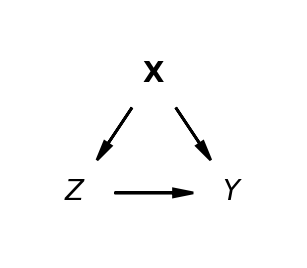

In [3]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("z", "$Z$", 1, 0)
pgm.add_node("x", "$\mathbf{X}$", 1.5, 0.75)
pgm.add_node("y", "$Y$", 2, 0)

pgm.add_edge("z", "y")
pgm.add_edge("x", "y")
pgm.add_edge("x", "z")

pgm.render();

One way to tell that our estimate of the causal relationship $Z \rightarrow Y$ may be biased is the presence of a backdoor path, $Z \leftarrow \mathbf{X} \rightarrow Y$. This path type is known as a "fork". Because $\mathbf{X}$ is a common cause of $Z$ and $Y$, any observed statistical relation between $Z$ and $Y$ may be due to the confounding effect of $\mathbf{X}$. 

Backdoor paths are problematic because they introduce _statistical associations_ between variables that do not reflect the true causal relationships, potentially leading to biased causal estimates. For example, if we ran a regression of the form `y ~ z`, and observe a main effect of $Z$ on $Y$, we have no way of knowing if this represents a true causal impact of $Z$ on $Y$, or if it is due to the confounding effect of $\mathbf{X}$. 

One approach is to "close the backdoor path" by conditioning on the confounding variables. Practically, this could involve including confounders $\mathbf{X}$ as a covariate in a regression model such as: `y ~ z + x₁ + x₂ + x₃`. Without explaining why, the coefficient for the main effect of $Z$ would now be an unbiased estimate of the _causal_ effect of $Z \rightarrow Y$.

However, unless we are very sure that we have accurate measures of _all_ confounding variables (maybe there is an $x_4$ that we don't know about or couldn't measure), it is still possible that our estimate of the causal effect is biased.

This leads us to Randomized Controlled Trials (RCTs) which are considered the gold standard for estimating causal effects. One reason for this is that we (as experimenters) intervene in the system by assigning units to treatment by {term}`random assignment`. Because of this intervention, any causal influence of the confounders upon the treatment $\mathbf{X} \rightarrow Z$ is broken - treamtent is now soley determined by the randomisation process, $R \rightarrow T$. The following causal DAG illustrates the structure of an RCT.

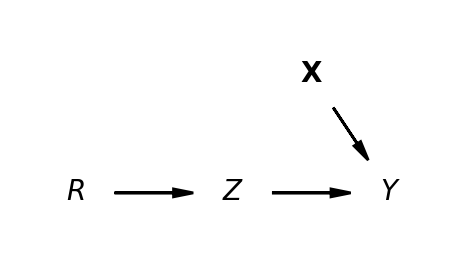

In [4]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("r", "$R$", 0, 0)
pgm.add_node("z", "$Z$", 1, 0)
pgm.add_node("x", "$\mathbf{X}$", 1.5, 0.75)
pgm.add_node("y", "$Y$", 2, 0)

pgm.add_edge("r", "z")
pgm.add_edge("z", "y")
pgm.add_edge("x", "y")

pgm.render();

The new variable $R$ represents the random assignment of units to the treatment group. This means that the treatment effect $Z \rightarrow Y$ can be estimated without bias.

## Instrumental Variables

In quasi-experiments, we cannot randomly assign subjects to treatment groups. So confounders $\mathbf{X}$ will still influence treatment assignment. In the instrumental variable (IV) approach, the causal effect of $Z \rightarrow Y$ is identifiable if we have an IV that causally influences the treatment $Z$ but not the outcome $Y$.

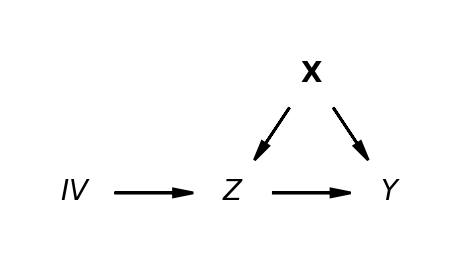

In [5]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("iv", "$IV$", 0, 0)
pgm.add_node("z", "$Z$", 1, 0)
pgm.add_node("y", "$Y$", 2, 0)
pgm.add_node("x", "$\mathbf{X}$", 1.5, 0.75)
pgm.add_edge("iv", "z")
pgm.add_edge("x", "z")
pgm.add_edge("x", "y")
pgm.add_edge("z", "y")

pgm.render();

Let's try to get some intuition of why having the $IV$ helps:
* The presence of $\mathbf{X}$ is a confounder because it influences both $Z$ and $Y$.
* But the $IV$ helps overcome this confounding because it is not influenced by $\mathbf{X}$.
* Any association between the $IV$ and $Y$ must be through the treatment $Z$.
* This means that the $IV$ can be used to estimate the causal effect of $Z \rightarrow Y$, without being confounded by $\mathbf{X}$. Informally, the $IV$ causes some variation in the treatment $Z$ that is not due to $\mathbf{X}$, and this variation can be used to estimate the causal effect of $Z \rightarrow Y$.

Readers are referred to {cite:t}`steiner2017graphical,cunningham2021causal` or {cite:t}`huntington2021effect` for a more in-depth discussion of the IV approach from the causal DAG perspective.

## Interrupted Time Series

A causal DAG for interrupted time series is given in Chapter 17 of {cite:t}`huntington2021effect`, though uses the [Event Study](https://theeffectbook.net/ch-EventStudies.html) label. These kinds of studies are suited to situations where an intervention is made at a given point in time at which we move from untreated to treated. Typically, we consider situations where there are a 'decent' number of observations over time. Here's the causal DAG - note that $\text{time}$ represents all the things changing over time such as the time index as well as time-varying predictor variables.

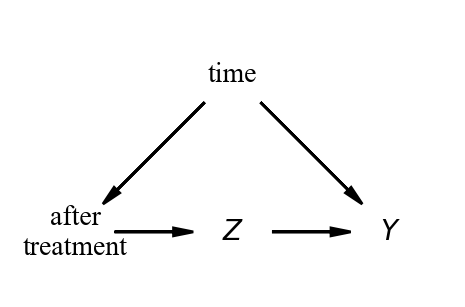

In [6]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("a", "after\ntreatment", -1, 0)
pgm.add_node("z", "$Z$", 0, 0)
pgm.add_node("y", "$Y$", 1, 0)
pgm.add_node("t", "time", 0, 1)

pgm.add_edge("a", "z")
pgm.add_edge("t", "a")
pgm.add_edge("t", "y")
pgm.add_edge("z", "y")

pgm.render();

What we want to understand is the causal effect of the treatment upon the outcome, $Z \rightarrow Y$. But we have a back door path between $Z$ and $Y$ which will make this hard, $Z \leftarrow \text{after treatment} \leftarrow \text{time} \rightarrow Y$.

The approach taken is:
1. Use the pre-treatment data only to create a prediction of what would have happened in the absence of treatment (i.e. the counterfactual). Splitting the dataset like this breaks the back door by removing any variation in $\text{after treatment}$, all values are 0.
2. If we can assume that in the absence of the treatment, nothing would have changed, then this counterfactual estimate will be unbiased and we can estimate the treatment effect by comparing the observed (post-treatment) data (where all values of $\text{after treatment}$ are 1) with the counterfactual. 

## Difference in Differences

Difference in Difference studies involve comparing the change in outcomes over time between a treatment and control group. The causal DAG for this is given in Chapter 18 of {cite:t}`huntington2021effect`:

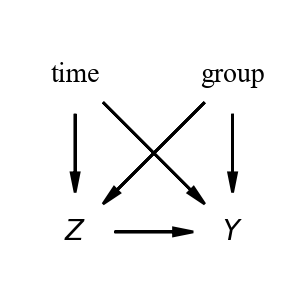

In [8]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("z", "$Z$", 0, 0)
pgm.add_node("y", "$Y$", 1, 0)
pgm.add_node("t", "time", 0, 1)
pgm.add_node("g", "group", 1, 1)
pgm.add_edge("t", "z")
pgm.add_edge("t", "y")
pgm.add_edge("g", "z")
pgm.add_edge("g", "y")
pgm.add_edge("z", "y")
pgm.render();

Readers are referred to Chapter 18 of {cite:t}`huntington2021effect` for more discussion on the causal DAG for Difference in Differences studies.

:::{warning}
This section is unfinished
:::

## Regression Discontinuity
 
The causal graph for the regression discontinuity design is shown below (left). $A$ is a continuous running variable which determines the treatment assignment $A \rightarrow Z$. Assignment is based on a cutoff value $a_c$. The running variable may also influence the outcome $A \rightarrow Y$. The running variable may also be associated with a set of variables $\mathbf{X}$ that influence the outcome, $A - - - - \mathbf{X}$.

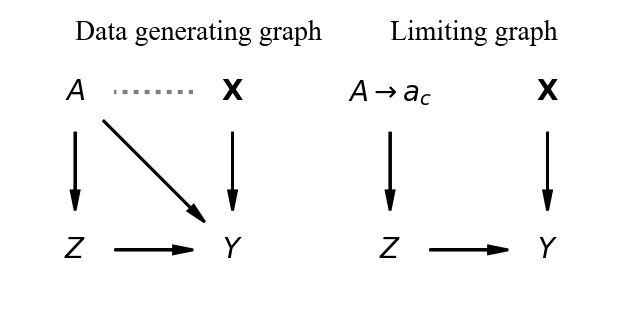

In [9]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

# data generating graph
pgm.add_node("a", "$A$", 0, 1)
pgm.add_node("z", "$Z$", 0, 0)
pgm.add_node("x", "$\mathbf{X}$", 1, 1)
pgm.add_node("y", "$Y$", 1, 0)
pgm.add_edge("a", "z")
pgm.add_edge("a", "y")
pgm.add_edge(
    "a",
    "x",
    plot_params={"ec": "grey", "lw": 1.5, "ls": ":", "head_length": 0, "head_width": 0},
)
pgm.add_edge("z", "y")
pgm.add_edge("x", "y")
pgm.add_text(0, 1.3, "Data generating graph")

# limiting graph
x_offset = 2
pgm.add_node("a2", r"$A \rightarrow a_c$", 0 + x_offset, 1)
pgm.add_node("z2", "$Z$", 0 + x_offset, 0)
pgm.add_node("x2", "$\mathbf{X}$", 1 + x_offset, 1)
pgm.add_node("y2", "$Y$", 1 + x_offset, 0)
pgm.add_edge("a2", "z2")
pgm.add_edge("z2", "y2")
pgm.add_edge("x2", "y2")
pgm.add_text(x_offset, 1.3, "Limiting graph")

pgm.render();

The causal effect of $Z \rightarrow Y$ is identified by comparing the outcome for units just above and just below the cutoff value, $A \rightarrow a_c$.

Readers are referred to {cite:t}`steiner2017graphical` and {cite:t}`cunningham2021causal` who discuss limiting graphs in more detail. 

:::{warning}
This section is unfinished
:::

## References
:::{bibliography}
:filter: docname in docnames
:::